# Scarcity Model elements
This is meant to illustrate the process of putting together the data on population change, grain inputs, assumptions about how those calories are consumed over time and across the population, and initial BMI levels to understand the evolution of famine. The results should not be considered definitive until rigerously analyzed, but they are roughly based on the methods described in the Clingendael Institute reports (but all errors are ours alone!):

- [Sudan: From hunger to death](https://www.clingendael.org/publication/sudan-hunger-death) 
2024-05-24, Dr. Timmo Gaasbeek. 

- [From Catastrophe to Famine: Immediate action needed in Sudan to contain mass starvation](https://www.clingendael.org/publication/catastrophe-famine-immediate-action-needed-sudan-contain-mass-starvation) 2024-02-08. Anette Hoffmann. 

At some points we likely diverge from their approach, such as in the linear and piecewise linear approaches to initial BMI levels, and in the distribution of calories across the population.

## Overview of Model Steps

In each month, for each percentile, the model updates population numbers, grain consumption, BMI, and calculates excess mortality. This must be done sequentially since the next month's calculations depend on the previous month's. Here are the steps, with reference to the relevant function (see `models.py` for details):

1. **Update grain stock** (`update_grain_stock`):
   - For each month, the grain stock is updated based on the grain input and current available stock.

2. **Calculate total calories** (`calculate_total_calories`):
   - The total caloric demand for the month is computed based on total consumption and days in the month, then converted into available kilocalories per day.

3. **Distribute calories among percentiles** (`distribute_calories`):
   - Caloric intake is distributed across the population based on a specified distribution method (linear or piecewise linear). This determines how many calories each percentile group consumes.
   - The total grain consumed is updated, and the remaining grain stock is calculated.

4. **Update BMI values** (`update_bmi_values`):
   - For each percentile group that is still alive, the energy deficit is calculated based on cereal intake, BMI, and energy requirements. This deficit is used to update BMI values for the population.

5. **Calculate mortality** (`calculate_mortality`):
   - Mortality is calculated based on two factors:
     - **Critical BMI**: The literature suggests a critical level of BMI at which humans cannot survive. If a population group falls below this, it is taken out of the analysis in future rounds (`alive` mask to prevent negative values, etc.)
     - **Excess mortality**: For remaining alive groups, excess mortality is calculated based on BMI, leading to further population reductions.

6. **Update population figures** (`update_population`):
   - Monthly population changes (births, deaths, and migration) are distributed evenly among the surviving percentile groups. Population totals are adjusted to reflect these changes, ensuring no population values go negative.

7. **Record monthly results** (`record_monthly_values`,`record_percentile_values`):
   - The model stores key statistics for each month, including grain stock, consumption, deaths (due to BMI, excess mortality, and natural causes), and total population. Another set of data includes specific stats for each percentile group (e.g., population, BMI, calorie intake).

At the end, the model provides:
- **Monthly summary data**: Available through the `get_results()` function.
- **Detailed percentile data**: Available through the `get_percentile_data()` function.

In [1]:

import pandas as pd
import warnings

import os
import re
import json
import numpy as np

from pathlib import Path
import math
import warnings
import matplotlib.pyplot as plt


try: # identify if in colab to fix paths
    import google.colab
    IN_COLAB = True
    print("colab identified.")
except ImportError:
    IN_COLAB = False

In [2]:
# clone the repository to access the data

!git clone https://github.com/aristotle-tek/famine-prediction.git


In [ ]:
if IN_COLAB: # fix for paths in colab
    base_path = Path('/content/famine-prediction')
else:
    try:
        base_path = Path(__file__).resolve().parent.parent
    except NameError:
        base_path = Path.cwd().parent.parent
print("Base path: ", base_path)

In [9]:
os.chdir(base_path)
from src.models import ResourceScarcityModel


## Setup - initialization, assumptions

For now we will focus on modeling October 2023-September 2024. Our analysis will model each percentile of the population separately, for each month. We input some choices about how to model the distribution of calories across the population (details below), and an initial distribution of BMI across the percentiles.

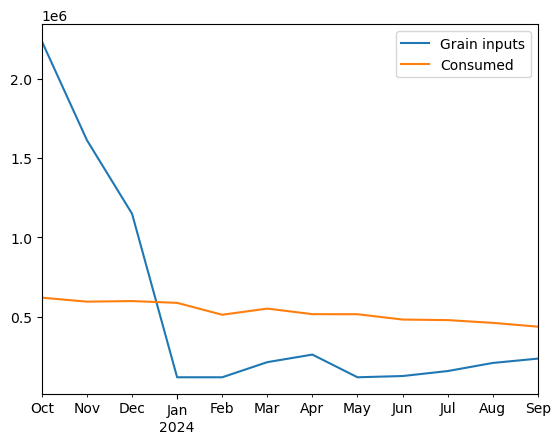

In [7]:

# Configuration parameters
config = {
    'total_pop': 48.6e6,
    'grain_percentage': 0.70,
    'grain_stock': [
        2235333.25,  # Opening stock
        1612401,     # input for Oct 2023 (not Sept)
        1149472.25,
        119215,
        119215,
        214471,
        262099,
        119215,
        127055,
        158415,
        209375,
        236815
    ],
    'start_year': 2023,
    'start_month': 10,
    'num_months': 12,
    'monthly_total_demand': [
        620553.9045, 595536.1334, 599163.7419, 587906.9105,
        513001.394, 551827.9642, 516732.8528, 516273.2652,
        482784.4238, 479255.9897, 461943.8986, 438037.1914
    ],
    'calories_per_metric_ton': 3_500_000,
    'bmi_init_method': 'linear',  # 'linear', logarithmic,  or 'reference'
    'top_bmi': 30,                   # for if 'linear' or logarithmic method is selected
    'distrib_method': 'piecewise_linear',  # 'linear' or 'piecewise_linear'
    'distrib_beta1': 3, # slope of the linear distribution or of the first segm of the linear piecewise
    'distrib_c': 80,
    'critical_bmi': 10.0
}

# Optional - small plot to show the grain inputs and consumption
pd.DataFrame({'Grain inputs': config['grain_stock'], 'Consumed': config['monthly_total_demand']}, index=pd.date_range(start=f"{config['start_year']}-{config['start_month']:02d}", periods=config['num_months'], freq='ME')).plot(); plt.show()



## Consumption of stocks over time
Note that there are various ways one could consume one year's worth of stocks of food, subject to not consuming more than is available. Later, we could consider optimal distributions, or other more realistic options, but for now we'll just assume the above consumption, which is roughly decreasing over time, until basically all stocks are consumed by the end of the lean season (September 2024).

## More details on implementation
The above does not provide much detail on the contents of the scarcityModel class, the details of which are in the models.py file. So here we walk through some of the main assumptions.

## Initial BMI distribution

Within each percentile of the population, we will assume that higher percentiles ("richer") people both:
1. start with initially higher (body-mass index 'BMI') and
2. consume more calories in a given period (or at least don't consume less than a lower percentile)

For now we consider three ways of modeling BMI, one is from an external source. A second is simply a linear interpolation between, say, 18 and 30, while the third logistic approach reflects the idea that much of the population might have access to a similar caloric intake but a small part of the population lives very precariously.

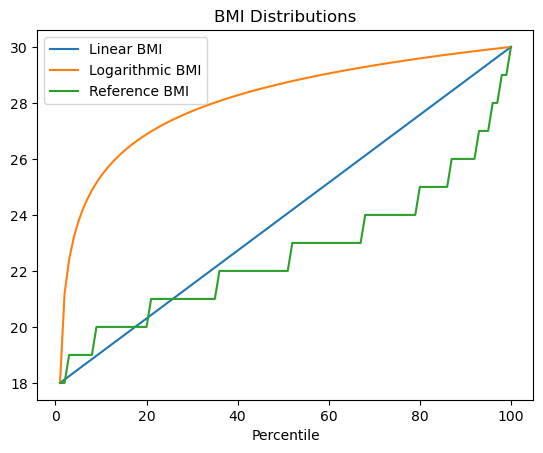

,Percentile,Linear BMI,Logarithmic BMI,Reference BMI
0,1,18.000000,18.000000,18
1,2,18.121212,21.187771,18
2,3,18.242424,22.400483,19
3,4,18.363636,23.178549,19
4,5,18.484848,23.748853,19


In [30]:
# Create distributions for both linear and logarithmic methods
linear_bmi = BMIDistribution(method='linear').get_bmi_distribution()
logarithmic_bmi = BMIDistribution(method='logarithmic').get_bmi_distribution()
data_file = base_path / 'data' / 'processed' / 'Combined_2024-09-22.xlsx'
ref_bmi  = BMIDistribution(method='reference', data_file=data_file)
bmi_init = ref_bmi.get_bmi_distribution()
bmi_init.sort() # sort is not in the reference but appears better for plotting

# Create a DataFrame to plot
df = pd.DataFrame({
    'Percentile': np.arange(1, 101),
    'Linear BMI': linear_bmi,
    'Logarithmic BMI': logarithmic_bmi,
    'Reference BMI': bmi_init
})

# Plot the distributions
df.plot(x='Percentile', y=['Linear BMI', 'Logarithmic BMI', 'Reference BMI'], title="BMI Distributions", grid=False)
plt.show()
df.head()

## How to distribute calories across the population

Once we know that a given amount of calories are consumed by the population, there are a number of ways of distributing those calories across the population. Two extremes would be (a) completely equal sharing of all calories by the population, or (b) all calories are consumed by the top percentile. We assume that the function that distributes calories is however relatively smooth and non-decreasing.

For now we consider two simple functions, a linear function (with alpha1 as a slope of the line), and a 2-segment piecewise linear function which is has slope alpha1 up until percentile $c$, then is 'flat', to reflect that all people who have the means to do so consume an adequate number of calories (subject to the overall society budget constraint).

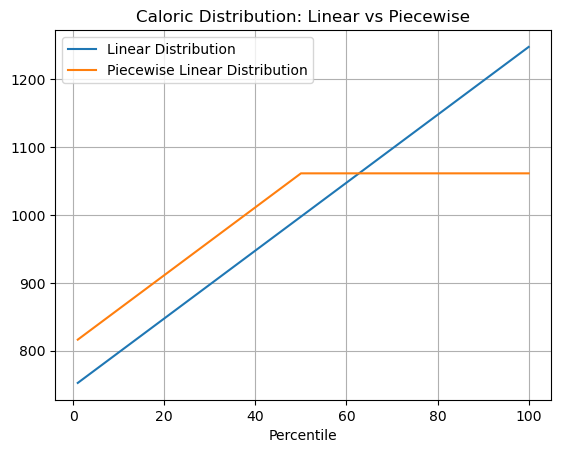

In [32]:
# To plot this simply, let's assume an equal population per percentile group
pop_per_percentile = np.ones(100)

# Total caloric consumption (arbitrary value)
total_kcal_consumption = 100000  # total calories per day

distributor = CalorieDistributor(pop_per_percentile, total_kcal_consumption)

# Generate distributions
linear_kcal = distributor.linear_distribution(beta1=5)
piecewise_kcal = distributor.piecewise_linear_distribution(beta1=5, c=50)

# create a df to plot
df_kcal = pd.DataFrame({
    'Percentile': np.arange(1, 101),
    'Linear Distribution': linear_kcal,
    'Piecewise Linear Distribution': piecewise_kcal
})

df_kcal.plot(x='Percentile', y=['Linear Distribution', 'Piecewise Linear Distribution'], title="Caloric Distribution: Linear vs Piecewise", grid=True)
plt.show()

## Caveats and Next steps
This is meant to illustrate the process, in future work we will rigorously test alternative approaches and premises. The results from the above model should not be taken as reliable in this illustration.